# FarmVibes.AI Micro Climate Prediction

This notebook demonstrates how to train a model to forecast weather. It provides configuration to train a model and perform inference for Temperature and WindSpeed.


### Micromamba environment setup
Before running this notebook, let's build a micromamba environment. If you do not have micromamba installed, please follow the instructions from the [micromamba installation guide](https://mamba.readthedocs.io/en/latest/installation/micromamba-installation.html).

```bash
$ micromamba env create -f ./deepmc_env.yaml
$ micromamba activate deepmc-pytorch
```

**We currently only support Unix-based systems (Linux and MacOS) for running this notebook.**

### Notebook outline
The notebook is configured to train a model to infer weather parameters such as Temperature and WindSpeed. To execute the notebook, users must provide input data downloaded from a weather station. 

The **required weather features** to execute the notebook are datetime, humidity, windspeed and temperature. 
For **model training**, a minimum of 2 years of input historical data is required. Whereas, for **inference**, 552 data points of historical data are required. 

Below are the main libraries used for this example and other useful links:
- [Pytorch](https://pytorch.org/) is used as our deep learning framework.
- [Scikit-Learn](https://github.com/scikit-learn/scikit-learn) is a Python package for machine learning built on top of SciPy. It consists of simple and efficient tools for predictive data analysis.
- [pandas](https://github.com/scikit-learn/scikit-learn) is a Python package that provides fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive.
- [NumPy](https://github.com/numpy/numpy) is a python package that provides powerful N-dimensional array object, broadcasting functions and useful linear algebra, Fourier transform, and random number capabilities.
- [pywt](https://github.com/PyWavelets/pywt) is a python package that provides mathematical basis functions that are localized in both time and frequency.


### Code organization
The training script relies on packages in `./notebook_lib` directory:

- The preprocess module (`notebook_lib/preprocess.py`) is used to preprocess, transform the input data and bundle the input data into chunks that are used for training the Micro Climate Prediction model. For more information on wavelets (check [pywavelets documentation](https://pywavelets.readthedocs.io/en/latest/)).
- The model module (`notebook_lib/models.py`, `notebook_lib/modules.py`) contains the code for designing the model with a set of sequential layers. If you want to change the design of the model and understand the pytorch layers, this is probably where you should go to. Also check [pytorch documentation](https://pytorch.org/docs/stable/nn.html).
- The train/inference modules (`notebook_lib/train.py` and `notebook_lib/predict.py`) contain the code for running/training/evaluating the neural network: instantiating the neural network, training steps, computing metrics, and others. If you want to understand the mode performance, the loss, and generally how the model is trained, this is probably where you should go to.
- The module `notebook_lib/utils.py` contains commonly used functions to read csv files, scale and split data, etc.

### Imports & Constants

In [ ]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from notebook_lib import train
from shapely import geometry

from vibe_notebook.deepmc import prediction, utils
from vibe_notebook.deepmc.forecast import Forecast

warnings.filterwarnings("ignore")

### Workflows
The notebook utilizes the workflow below, which is available in FarmVibes.AI: 

In [2]:
HERBIE_DOWNLOAD_WORKFLOW = "data_ingestion/weather/herbie_forecast"

### Data
The notebook utilizes two types of datasets:

1. The historical observations recorded by weather stations.
2. The forecast observations downloaded using the [herbie package](https://blaylockbk.github.io/Herbie/_build/html/). This package helps to download recent and archived numerical weather prediction (NWP) model output from different cloud archive sources. Its most popular capability is to download HRRR model data.


### AGWeatherNet
In this notebook, we utilize historical observations downloaded from AGWeatherNet for the station `Palouse`. The data used for training range from May 2020 to June 2022. For more information check [AGWeatherNet documentation](http://weather.wsu.edu/?p=92850&desktop).

In [3]:
# AGWeatherNet station
STATION_NAME = "Palouse"
STATION_LOCATION = (-117.22, 46.93)
STATION_GEOMETRY = geometry.Point(STATION_LOCATION)

### Variables

In [4]:
PREDICT = "%s"
RELEVANT = "%s"
ROOT_PATH = f"./data/model_{PREDICT}/"
DATA_EXPORT_PATH = ROOT_PATH + f"{STATION_NAME}/{RELEVANT}/train_data.pkl"

### Historical observations Variables

In [5]:
# weather dataset filtered and model training limited to train features.
HISTORICAL_MODEL_TRAIN_FEATURES = ["humidity", "wind_speed", "temperature"]

# Historical data aligned using INDEX variable
INDEX = "date"

### Forecast Observation Variables

In [6]:
# weather dataset filtered and model training limited to train features.
FORECAST_MODEL_TRAIN_FEATURES = ["humidity_forecast", "wind_speed_forecast", "temperature_forecast"]

### Predict Variables

In [7]:
# Models trained to predict out features
OUT_FEATURES = ["wind_speed", "temperature"]

### Relevant vs Not Relevant
The scenario is considered relevant when there is a close match between historical data and forecasts, with minimal discrepancies else it's not relevant.

The notebook supports performing micro climate predictions with the following approaches: 

1. Utilizing both Historical & Forecast observations. This approach is suggested to use if both observations are relevant. </br> </br>
<img src=notebook_lib/images/relevant.png width="700">
2. Utilizing only Historical dataset. This approach is suggested to use if both Historical & Forecast observations are not relevant or Forecast dataset doesn't exist. </br> </br>
<img src=notebook_lib/images/not-relevant.png width="700">

In next cells, we demonstrate the training and prediction processes for both relevant and non-relevant scenarios. 

In [8]:
RELEVANT_FEATURES = HISTORICAL_MODEL_TRAIN_FEATURES.copy()
RELEVANT_FEATURES.extend(FORECAST_MODEL_TRAIN_FEATURES)
RELEVANT_FEATURES.sort()
print(RELEVANT_FEATURES)

['humidity', 'humidity_forecast', 'temperature', 'temperature_forecast', 'wind_speed', 'wind_speed_forecast']


In [9]:
NON_RELEVANT_FEATURES = HISTORICAL_MODEL_TRAIN_FEATURES.copy()
NON_RELEVANT_FEATURES.sort()
print(NON_RELEVANT_FEATURES)

['humidity', 'temperature', 'wind_speed']


### Download Historical Observations for Model Training
The historical observations were downloaded from AGWeatherNet as a 15-minute frequency. On downloaded data, the following preprocessing steps are performed:

1. The index variable is converted to datetime
2. The input data is interpolated to fill the missing values using their neighbors
3. The script focuses on training the model with a 60-minute frequency, hence the data is grouped for this frequency.
4. The data is scaled using the scikit-learn StandardScalar. For more information check [scikit-learn documentation](https://github.com/scikit-learn/scikit-learn)

In [10]:
# Get actual observations data for a station
file_path = f"./data/{STATION_NAME}/training.csv"

### Pre-process Historical Observations

In [11]:
historical_dataset = utils.get_csv_data(path=file_path, interpolate=False, fill_na=False)

### Download forecast observations to train model
To initialize forecast observations download it requires below inputs.

1. time_range - It accepts the start datetime and end datetime of data to be downloaded.
2. station_location -  It accepts the coordinates of a weather station.
3. parameters - It accepts below parameters based on weather parameter.</br>

    a. fxx - It's grouping parameter of forecast observations by number of hours. It accepts the List of values in a format start, stop & step. </br> Below example representing the forecast observations group by 24 hours and incrementing by one hour.</br>
    &emsp; Example - [0, 24, 1] </br>
    b. interval - time gap between each observation. </br>
    c. weather_type - It represents the type of weather forecast data to be downloaded.</br>
    d. [search_text](https://blaylockbk.github.io/Herbie/_build/html/user_guide/searchString.html) - It varies by weather type. It accepts below search text. </br>
    &emsp;- temperature - "TMP:2 m" </br>
    &emsp;- humidity - "RH:2 m"  </br>
    &emsp;- wind speed - The forecast observations of wind speed are derived using data downloaded for u & v components. The algebraic expression used to calculate wind speed is </br>
        $$ 
            ws(u, v) = \sqrt{u^2 + v^2}
        $$
    &emsp; i. u component - "UGRD:10 m" </br>
    &emsp; ii. v component - "VGRD:10 m"

In [12]:
# fxx parameters
frequency_hour = 1
number_of_hours = 24

# hence fxx can be
fxx = [frequency_hour, number_of_hours + frequency_hour, 1]

In [13]:
start_date = datetime(year=2020, month=5, day=31)
end_date = datetime(year=2022, month=8, day=2)
time_range = (start_date, end_date)
date_column = "date"

parameters = [
    {"weather_type": "temperature", "search_text": "TMP:2 m"},
    {"weather_type": "humidity", "search_text": "RH:2 m"},
    {"weather_type": "u-component", "search_text": "UGRD:10 m"},
    {"weather_type": "v-component", "search_text": "VGRD:10 m"},
]

### Submit Request to Worker
We download forecast observations by submitting a request to the worker running in the background. If more than one worker instance is running in the background, the request is processed in parallel for each parameter. Workflow execution utilizes the parameters below while processing requests, this can be overwritten using the parameter argument.

- fxx: [1, 25, 1] # start, stop, step
- search_text: "TMP:2 m"
- interval: 60 # in minutes
- weather_type: "temperature"
- multi_threads: 25

In [14]:
forecast = Forecast(
    workflow_name=HERBIE_DOWNLOAD_WORKFLOW,
    geometry=STATION_GEOMETRY,
    time_range=time_range,
    parameters=parameters,
)
run_list = forecast.submit_download_request()

Output()

### Monitor download of Forecast observations
Check the download status and fetch the downloaded data from FarmVibes.AI. The execution time of the download depends on the time range. 

The downloaded data undergoes the following changes:

1. Concatenate the output of all submitted requests.
2. Set index on date column.
3. Interpolate to derive the missing data.
4. The data downloaded follows the UTC timezone. It's required to transform the data to the timezone of historical observations. The historical observations used in this notebook follows the PST timezone, hence the data is offset by -8 hours.

In [15]:
# transform downloaded data from utc to pst timezone
forecast_dataset = forecast.get_downloaded_data(run_list=run_list, offset_hours=-8)
forecast_dataset.to_csv(f"{STATION_NAME}_forecast.csv")
forecast_dataset.head(2)

Execution status for temperature: done
Execution status for humidity: done
Execution status for u-component: done
Execution status for v-component: done


,temperature_forecast,humidity_forecast,u-component_forecast,v-component_forecast
date,,,,
2020-05-30 16:00:00,302.135345,49.299999,-2.789404,1.464687
2020-05-30 17:00:00,301.010956,54.599998,-2.861307,1.178179


### Preprocess Forecast Observations

We perform the following preprocessing in the downloaded data before training the model.

- `temperature`: The downloaded data is in Kelvin. It will be converted to Fahrenheit.
- `wind_speed`: Using the u-component & v-component values downloaded, the `wind_speed` values are derived. The derived values are multiplied by 2.23 to convert from m/sec to mph.
- Drop u-component & v-component

In [17]:
forecast_dataset = utils.convert_forecast_data(forecast_dataset)
forecast_dataset.head(2)

We also clean the input data with the following operations:
- Exclude input data outside the time_range of interest.
- Shift forecast data by number of hours
- Fill missing data with neighboring data points using pandas interpolate techniques.

In [18]:
input_df = utils.clean_relevant_data_using_hrrr(
    actual_df=historical_dataset,
    forecast_df=forecast_dataset,
    out_variables=RELEVANT_FEATURES,
    freq_hours=frequency_hour,
    num_of_indices=number_of_hours,
    start_date=start_date,
    end_date=end_date,
)
input_df.head(2)

,humidity,humidity_forecast,temperature,temperature_forecast,wind_speed,wind_speed_forecast
date,,,,,,
2020-07-06 00:00:00,61.950,54.299999,59.75,58.707159,4.55,2.926392
2020-07-06 01:00:00,86.975,60.700001,49.90,57.220984,3.85,10.642863


### Verifying if the forecast observations are relevant or not relevant

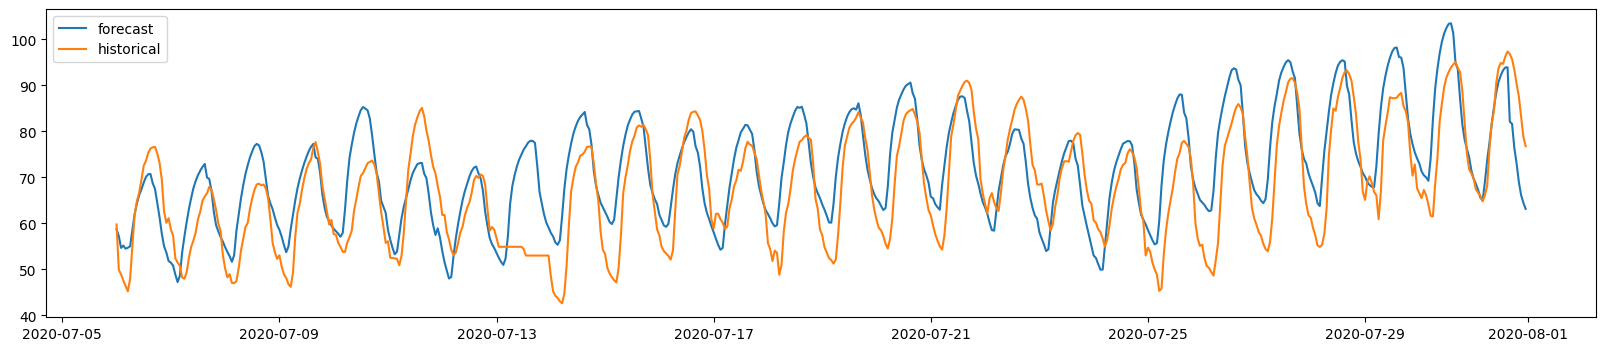

In [20]:
plot_df = input_df[(input_df.index.month == 7) & (input_df.index.year == 2020)]

plt.figure(figsize=(20, 4))
plt.plot(plot_df.index.values, plot_df["temperature_forecast"].values, label="forecast")
plt.plot(plot_df.index.values, plot_df["temperature"].values, label="historical")
plt.legend()

Based on the distribution of observation in above plot, the forecast observations are relevant. In this scenario, we will continue with model training using the relevant dataset.

### Training

The script is configured to train the Micro Climate prediction model for 24 hours and the historical weather station data has points with a 60-minute frequency. Below inputs vary based on the number of hours of prediction and frequency of weather station data points.

1. `chunk_size` - The value of the chunk size is based on the frequency of the weather station data points. For a frequency of 60 minutes, the minimum required data points are 528. If the data frequency is 15 minutes, the minimum number of data points required is 528*4 = 2112. These are the minimum number of data points need to be provided as input during the inference.
2. `ts_lookahead` - The value used during the data preprocessing. It is the value used to consider weather data points ahead for a given time period while grouping the data.
3. `ts_lookback` - The value used during the data preprocessing. It is the value used to consider weather data points back for a given time period while grouping the data.
4. `total_models` - To perform a 24-hour prediction with a weather data point having a frequency of 60 minutes, 24 models are required. One model for each 60-minute window. If the number of hours of prediction are increased, then the total number of data points are increased. 
5. `wavelet` - Wavelet object name used to perform discrete transformation of data. The current notebook is configured to use `bior3.5`. For more information check [Discrete Wavelet Transform documentation](https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html)

### Model Types
The training process creates two different types of models: 
1. `Micro climate prediction model` - Used to predict the weather forecast. 
2. `Micro climate post-prediction model`- Scale the predicted weather forecast values using the training input data and reduce the error in prediction output.

### Training model using relevant dataset

In [22]:
train_weather = train.ModelTrainWeather(
    train_features=RELEVANT_FEATURES,
    out_features=OUT_FEATURES,
    root_path=ROOT_PATH,
    data_export_path=DATA_EXPORT_PATH,
    station_name=STATION_NAME,
    relevant=True,
)

train_weather.train_model(input_df)

### Prediction using Relevant Datasets

### Current
To predict the weather for next 24 hours, we need certain hours of historical forecast observations beforehand. The default size (chunk size) of historical forecast observations is 528. Choosing a start time to predict is important, if historical observations used to train model have a starting time of 12:00:00, then the historical observations used for prediction should start at the same time.

In [23]:
weather_forecast = prediction.InferenceWeather(
    root_path=ROOT_PATH,
    data_export_path=DATA_EXPORT_PATH,
    station_name=STATION_NAME,
    predicts=OUT_FEATURES,
    relevant=True,
)

In [24]:
WORKFLOW_NAME = "data_ingestion/weather/herbie_forecast"
p_start_date = datetime(year=2022, month=3, day=18, hour=0, minute=0, second=0)
p_end_date = datetime(year=2022, month=6, day=3, hour=0, minute=0, second=0)

time_range = (p_start_date, p_end_date)
date_column = "date"

parameters = [
    {"weather_type": "temperature", "search_text": "TMP:2 m"},
    {"weather_type": "humidity", "search_text": "RH:2 m"},
    {"weather_type": "u-component", "search_text": "UGRD:10 m"},
    {"weather_type": "v-component", "search_text": "VGRD:10 m"},
]

In [25]:
forecast = Forecast(
    workflow_name=HERBIE_DOWNLOAD_WORKFLOW,
    geometry=STATION_GEOMETRY,
    time_range=time_range,
    parameters=parameters,
)
run_list = forecast.submit_download_request()

Output()

In [26]:
# transform downloaded data from utc to pst timezone
p_forecast_dataset = forecast.get_downloaded_data(run_list=run_list, offset_hours=-8)
p_forecast_dataset.to_csv(f"{STATION_NAME}_forecast.csv")
p_forecast_dataset.head(2)

Execution status for temperature: done
Execution status for humidity: done
Execution status for u-component: done
Execution status for v-component: done


,temperature_forecast,humidity_forecast,u-component_forecast,v-component_forecast
date,,,,
2022-03-17 16:00:00,282.774963,48.299999,2.835153,2.293570
2022-03-17 17:00:00,280.251770,60.700001,4.563419,1.176411


In [28]:
predict_file_path = f"./data/{STATION_NAME}/prediction.csv"
p_historical_dataset = utils.get_csv_data(path=predict_file_path, interpolate=False, fill_na=False)
p_historical_dataset = p_historical_dataset[HISTORICAL_MODEL_TRAIN_FEATURES]

p_historical_dataset.head(2)

,humidity,wind_speed,temperature
date,,,
2022-03-18 13:00:00,70.925,15.900,49.025
2022-03-18 14:00:00,66.300,16.175,50.075


In [30]:
p_forecast_dataset = utils.convert_forecast_data(p_forecast_dataset)

We clean the input data with the following operations:
- Exclude input data outside the time range of interest.
- Shift forecast data by number of hours
- Fill missing data with neighboring data points using pandas interpolate techniques.

In [31]:
input_df = utils.clean_relevant_data_using_hrrr(
    actual_df=p_historical_dataset.copy(),
    forecast_df=p_forecast_dataset.copy(),
    out_variables=RELEVANT_FEATURES,
    freq_hours=frequency_hour,
    num_of_indices=number_of_hours,
    start_date=start_date,
    end_date=end_date,
)

base_data_df = input_df[RELEVANT_FEATURES]
base_data_df.head(2)

,humidity,humidity_forecast,temperature,temperature_forecast,wind_speed,wind_speed_forecast
date,,,,,,
2022-03-18 13:00:00,70.925,84.099998,49.025,45.906879,15.900,18.552760
2022-03-18 14:00:00,66.300,83.800003,50.075,45.456384,16.175,17.855009


In [33]:
predict_start_datetime = base_data_df.index[-1]
df_output_merge = pd.DataFrame(columns=base_data_df.columns)
df_out = weather_forecast.inference(base_data_df.copy(), start_datetime=predict_start_datetime)

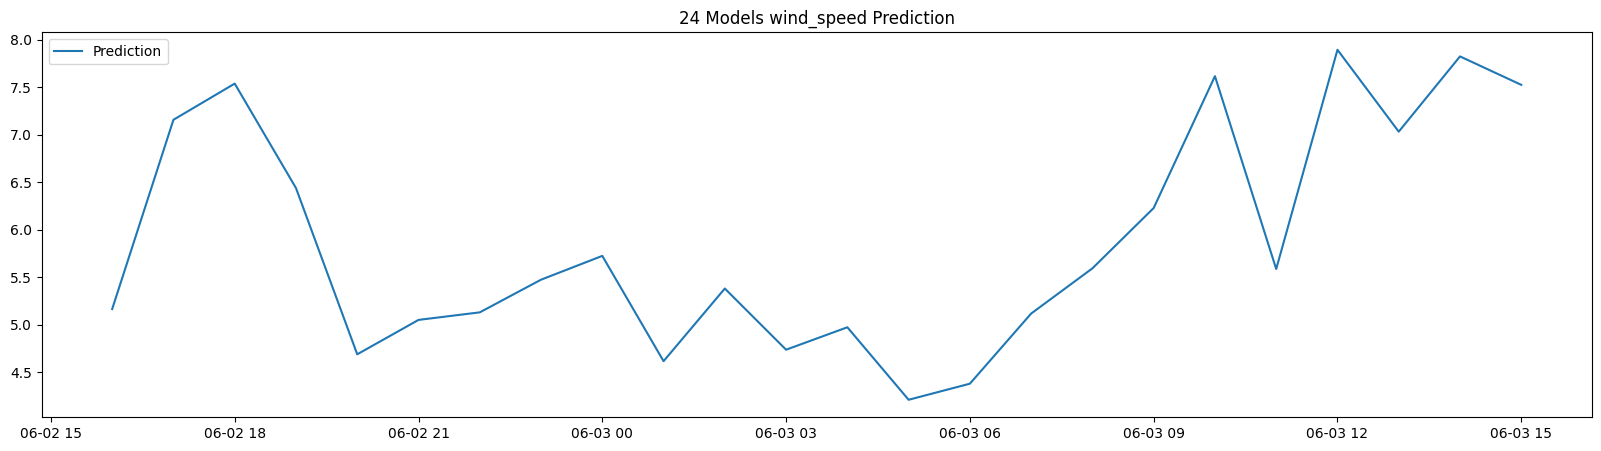

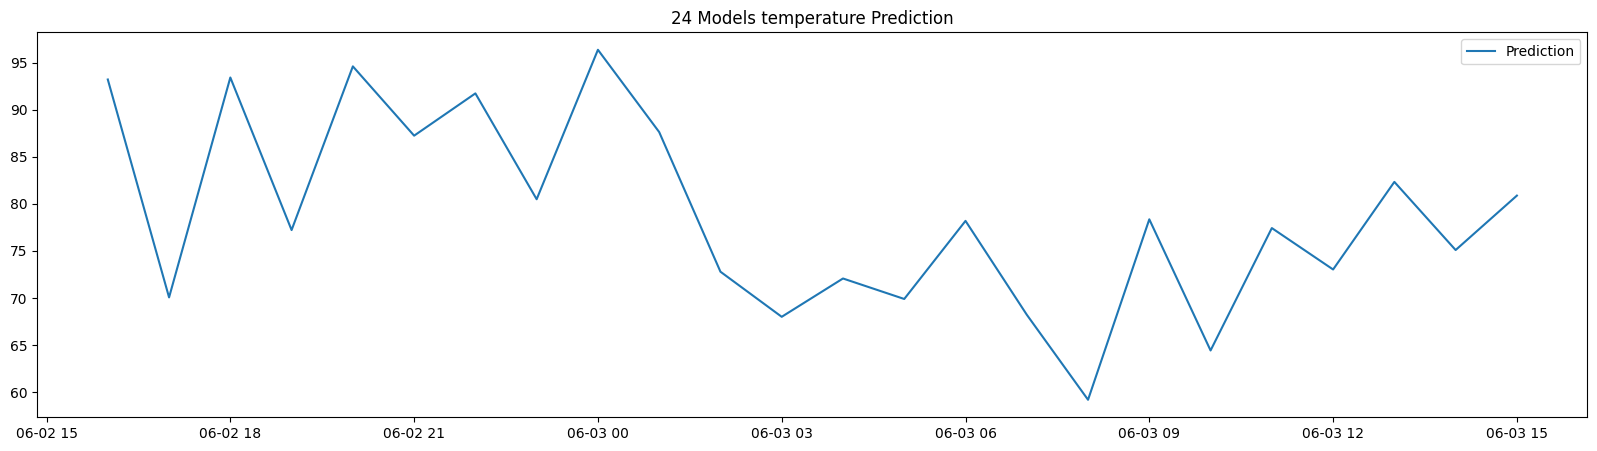

In [34]:
for predict in OUT_FEATURES:
    plt.figure(figsize=(20, 5))
    plt.plot(df_out["date"].values, df_out[predict].values)
    plt.title(f"24 Models {predict} Prediction")
    plt.legend(["Prediction"])

### Batch Forecast Prediction
Predict weather parameters using historical observations & forecast observations between specified start datetime and end datetime:

In [35]:
predict_file_path = f"./data/{STATION_NAME}/training.csv"
p_historical_dataset = utils.get_csv_data(path=predict_file_path, interpolate=False, fill_na=False)
p_historical_dataset = p_historical_dataset[HISTORICAL_MODEL_TRAIN_FEATURES]
p_historical_dataset.head(5)

input_df = utils.clean_relevant_data(
    p_historical_dataset.copy(),
    p_forecast_dataset.copy(),
    RELEVANT_FEATURES,
    freq_hours=frequency_hour,
    num_of_indices=number_of_hours,
)
base_data_df = input_df[RELEVANT_FEATURES]
base_data_df.head(2)

,humidity,humidity_forecast,temperature,temperature_forecast,wind_speed,wind_speed_forecast
date,,,,,,
2022-03-16 16:00:00,63.275,48.299999,45.750,49.324945,15.775,8.132181
2022-03-16 17:00:00,60.250,60.700001,45.425,44.783197,14.325,10.509131


In [37]:
predict_start_datetime = datetime(year=2022, month=4, day=30, hour=13, minute=0, second=0)
predict_end_datetime = datetime(year=2022, month=5, day=21, hour=13, minute=0, second=0)

df_out = weather_forecast.inference_historical(
    base_data_df.copy(), start_datetime=predict_start_datetime, end_datetime=predict_end_datetime
)

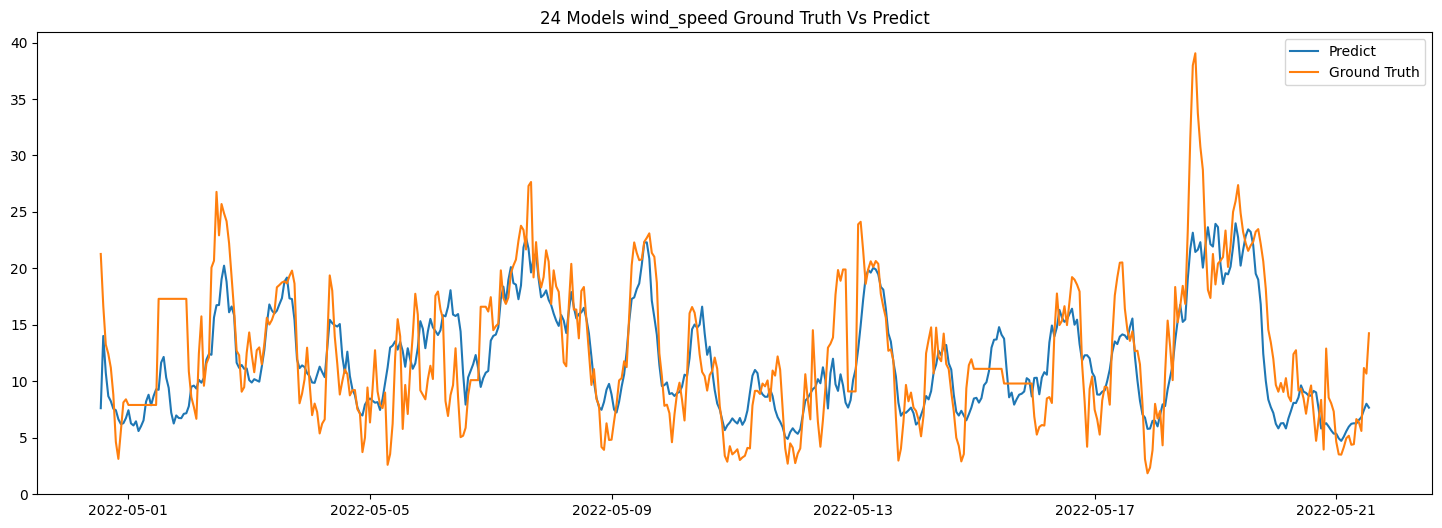

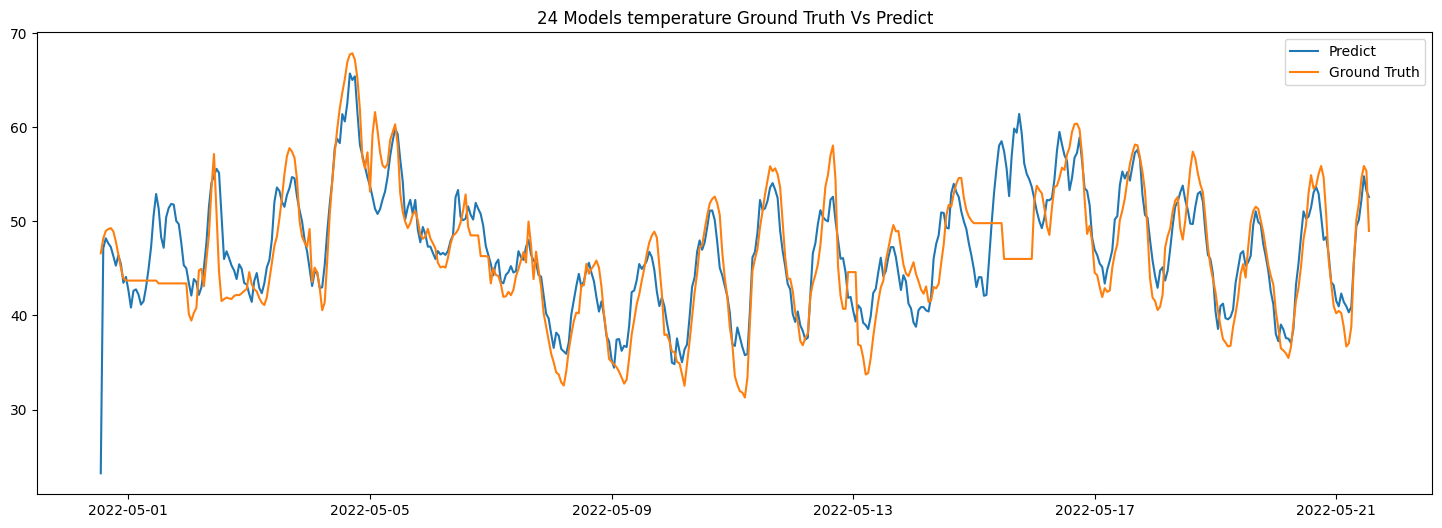

In [38]:
base_data_df = base_data_df[
    (base_data_df.index >= predict_start_datetime) & (base_data_df.index <= predict_end_datetime)
]

for predict in OUT_FEATURES:
    plt.figure(figsize=(18, 6))
    plt.plot(df_out["date"].values, utils.smooth(df_out[predict].values, 2), label="Prediction")
    plt.plot(base_data_df.index.values, base_data_df[predict].values, label="Ground Truth")

    plt.title(f"24 Models {predict} Ground Truth Vs Predict")
    plt.legend()

In [39]:
print("temperature")
utils.calculate_KPI(
    utils.smooth(list(df_out["temperature"].values), 1),
    np.array(base_data_df["temperature"].values),
)

print("\n", "wind_speed")
utils.calculate_KPI(
    utils.smooth(list(df_out["wind_speed"].values), 1), np.array(base_data_df["wind_speed"].values)
)

temperature
RMSE: 1.9672315572906003
MAE: 2.96
MAE%: 6.28%

 wind_speed
RMSE: 2.004993765576342
MAE: 3.01
MAE%: 25.32%


### Training model using non-relevant dataset or without forecast observations

In [40]:
# relevant input dataset
historical_df = historical_dataset[NON_RELEVANT_FEATURES]

In [41]:
train_weather = train.ModelTrainWeather(
    train_features=NON_RELEVANT_FEATURES,
    out_features=OUT_FEATURES,
    root_path=ROOT_PATH,
    data_export_path=DATA_EXPORT_PATH,
    station_name=STATION_NAME,
    relevant=False,
)

train_weather.train_model(historical_df, start=0, epochs=1)

### Predicting Weather forecast
The script in the notebook is configured to infer Micro Climate prediction model for 24 hours, with actual weather station data points with a frequency of 60 minutes.

In [42]:
weather_forecast = prediction.InferenceWeather(
    root_path=ROOT_PATH,
    data_export_path=DATA_EXPORT_PATH,
    station_name=STATION_NAME,
    predicts=OUT_FEATURES,
)

### Current
Predict weather for the next 24 hours:

In [43]:
file_path = f"./data/{STATION_NAME}/prediction.csv"
p_historical_df = utils.get_csv_data(path=file_path)

In [44]:
base_data_df = p_historical_df[NON_RELEVANT_FEATURES]

predict_start_datetime = base_data_df.index[-1]

df_output_merge = pd.DataFrame(columns=base_data_df.columns)

df_out = weather_forecast.inference(base_data_df, start_datetime=predict_start_datetime)

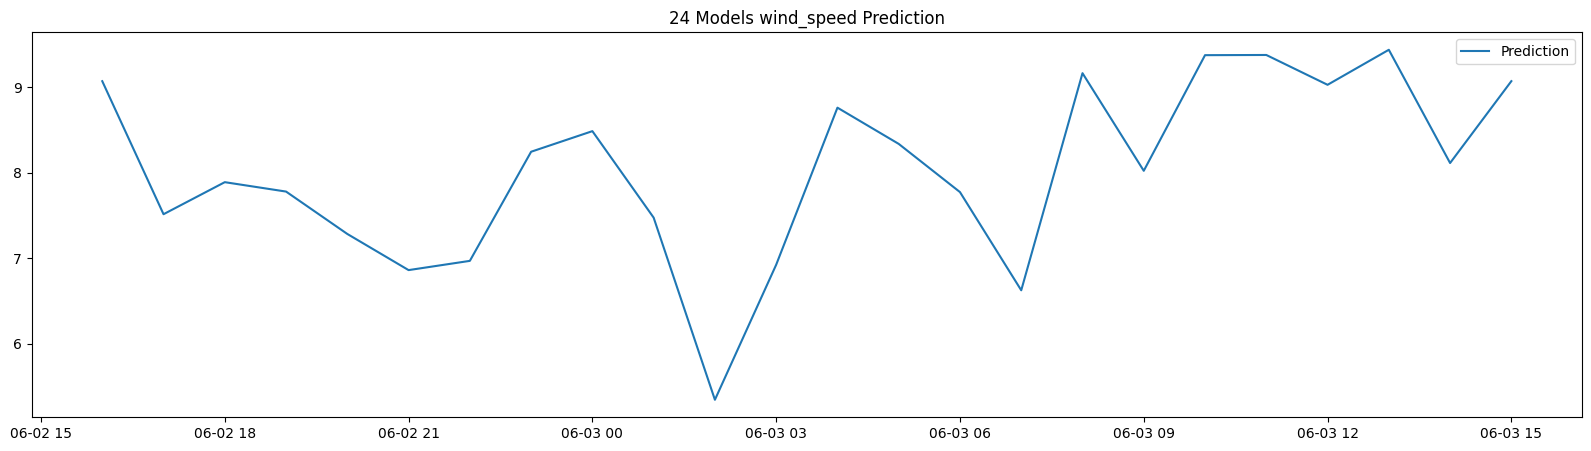

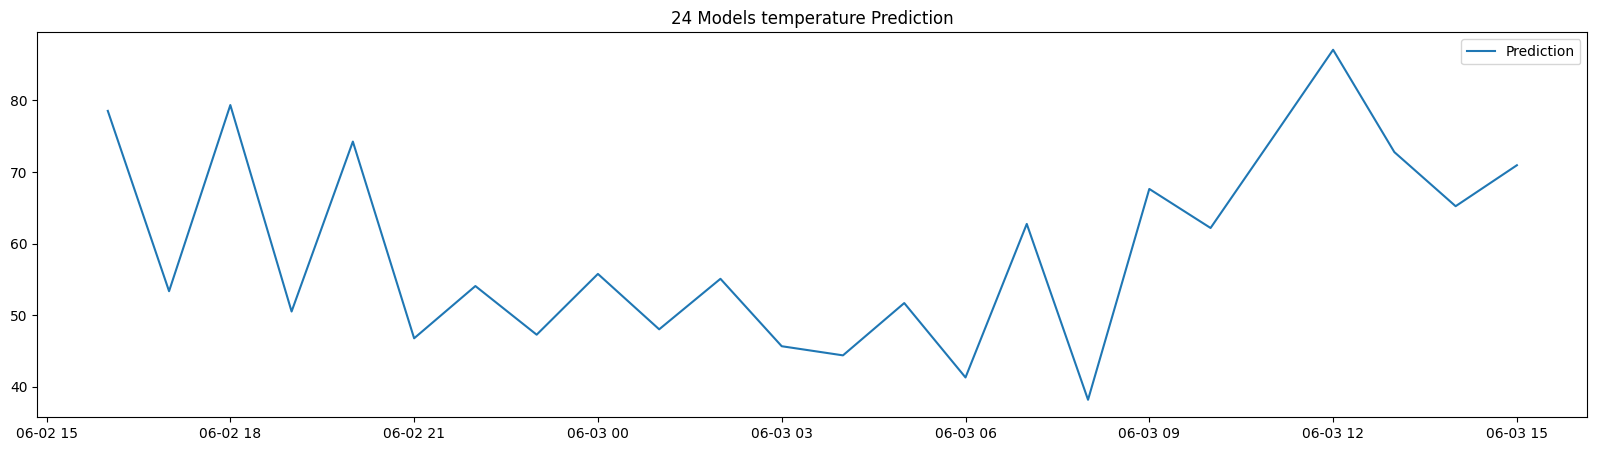

In [45]:
for predict in OUT_FEATURES:
    plt.figure(figsize=(20, 5))
    plt.plot(df_out["date"].values, df_out[predict].values)
    plt.title(f"24 Models {predict} Prediction")
    plt.legend(["Prediction"])

### Historical Prediction
Predict weather parameters using historical data between specified start datetime and end datetime:

In [46]:
file_path = f"./data/{STATION_NAME}/prediction.csv"
p_historical_df = utils.get_csv_data(path=file_path)
base_data_df = p_historical_df[NON_RELEVANT_FEATURES]

predict_start_datetime = datetime(year=2022, month=4, day=30, hour=13, minute=0, second=0)
predict_end_datetime = datetime(year=2022, month=5, day=21, hour=13, minute=0, second=0)

df_out = weather_forecast.inference_historical(
    base_data_df, start_datetime=predict_start_datetime, end_datetime=predict_end_datetime
)

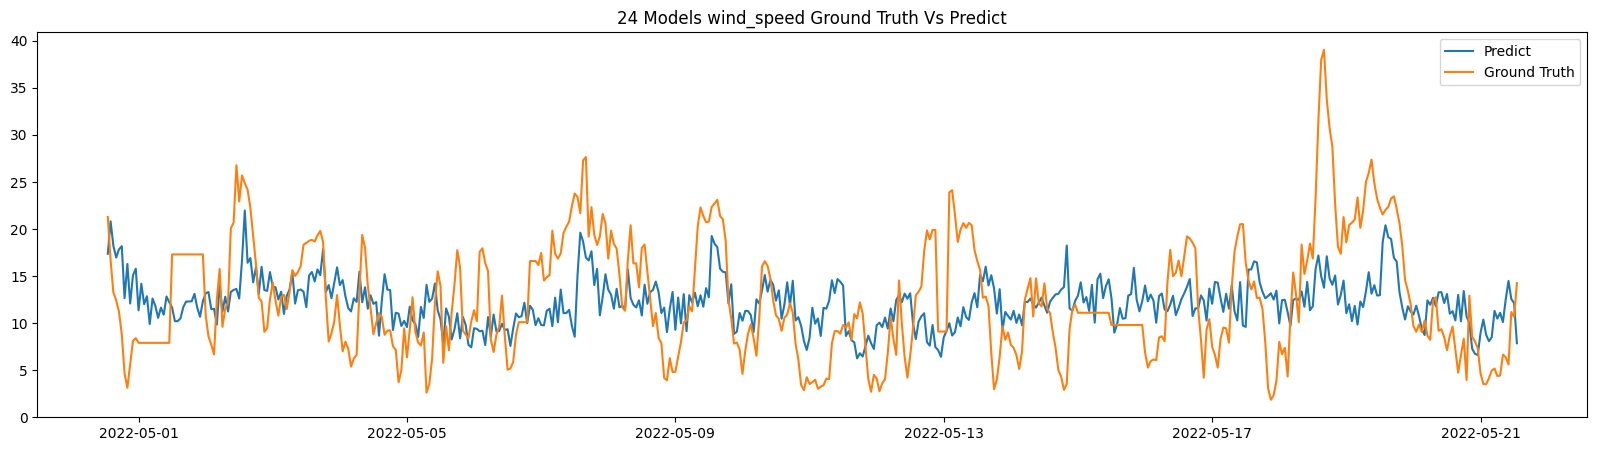

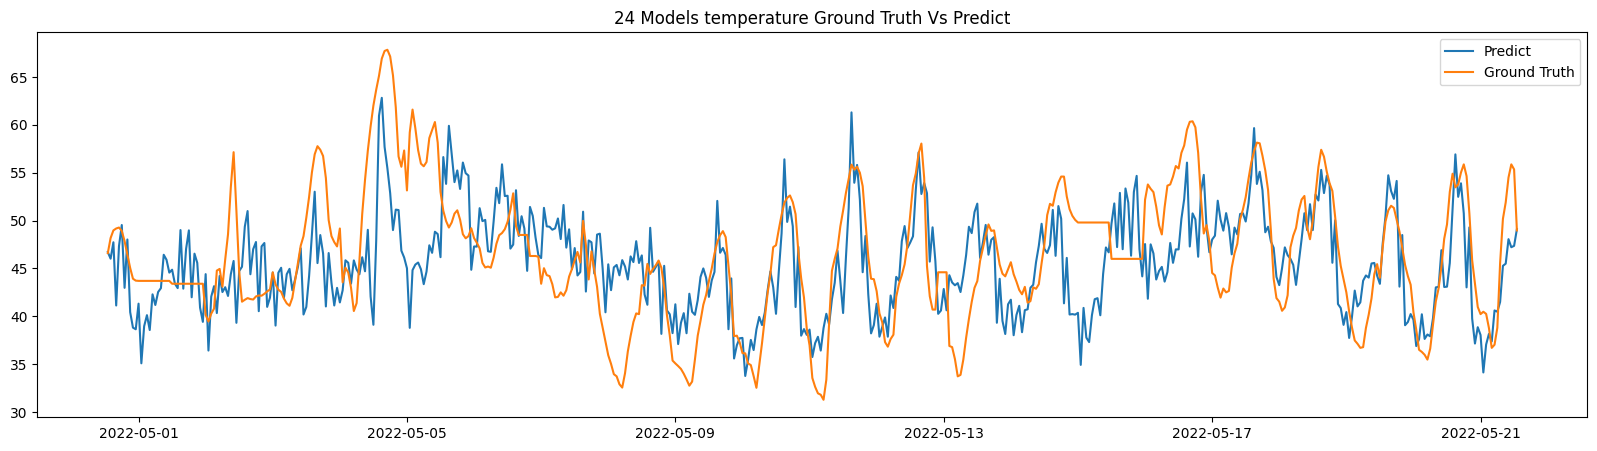

In [47]:
base_data_df = base_data_df[
    (base_data_df.index >= predict_start_datetime) & (base_data_df.index <= predict_end_datetime)
]
for predict in OUT_FEATURES:
    plt.figure(figsize=(20, 5))
    plt.plot(df_out["date"].values, df_out[predict].values)
    plt.plot(base_data_df.index.values, base_data_df[predict].values)
    plt.title(f"24 Models {predict} Ground Truth Vs Prediction")
    plt.legend(["Predict", "Ground Truth"])